# Matrix Factorisation - Implicit

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split, neg_feedback_samples
from reco.evaluate import user_item_crossjoin, filter_by

In [3]:
%matplotlib inline

## Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")
df_implicit = neg_feedback_samples(df_ratings, rating_threshold=3, ratio_neg_per_user=1)
df_implicit["unix_timestamp"] = 1


In [5]:
df_ratings.shape, df_implicit.shape

((100000, 4), (165040, 4))

In [6]:
DATA, user_encoder, item_encoder = encode_user_item(df_implicit, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [7]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [8]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(np.int64(0), np.int64(1))

In [9]:
train, test = random_split(DATA, [0.8, 0.2])

In [10]:
train.shape, test.shape

((132032, 7), (33008, 7))

# Implicit Matrix Factorisation

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils import model_to_dot
from reco import vis

In [12]:
def ImplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='binary_crossentropy', optimizer="sgd")
    
    return model

In [13]:
n_factors = 40
model = ImplicitMF(n_users, n_items, n_factors)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemEmbedding       │ (None, 1, 40)     │     67,280 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserEmbedding       │ (None, 1, 40)     │     37,720 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItemsE       │ (None, 40)        │          0 │ ItemEmbedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUsersE       │ (None, 40)        │          0 │ UserEmbedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DotProduct (Dot)    │ (None, 1)         │          0 │ FlattenItemsE[0]… │
│                     │                   │            │ FlattenUsersE[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,000 (410.16 KB)

 Trainable params: 105,000 (410.16 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from reco.utils import create_directory
create_directory("/model-img")

Directory already exists d:\Work\Development\recommendation_system/model-img


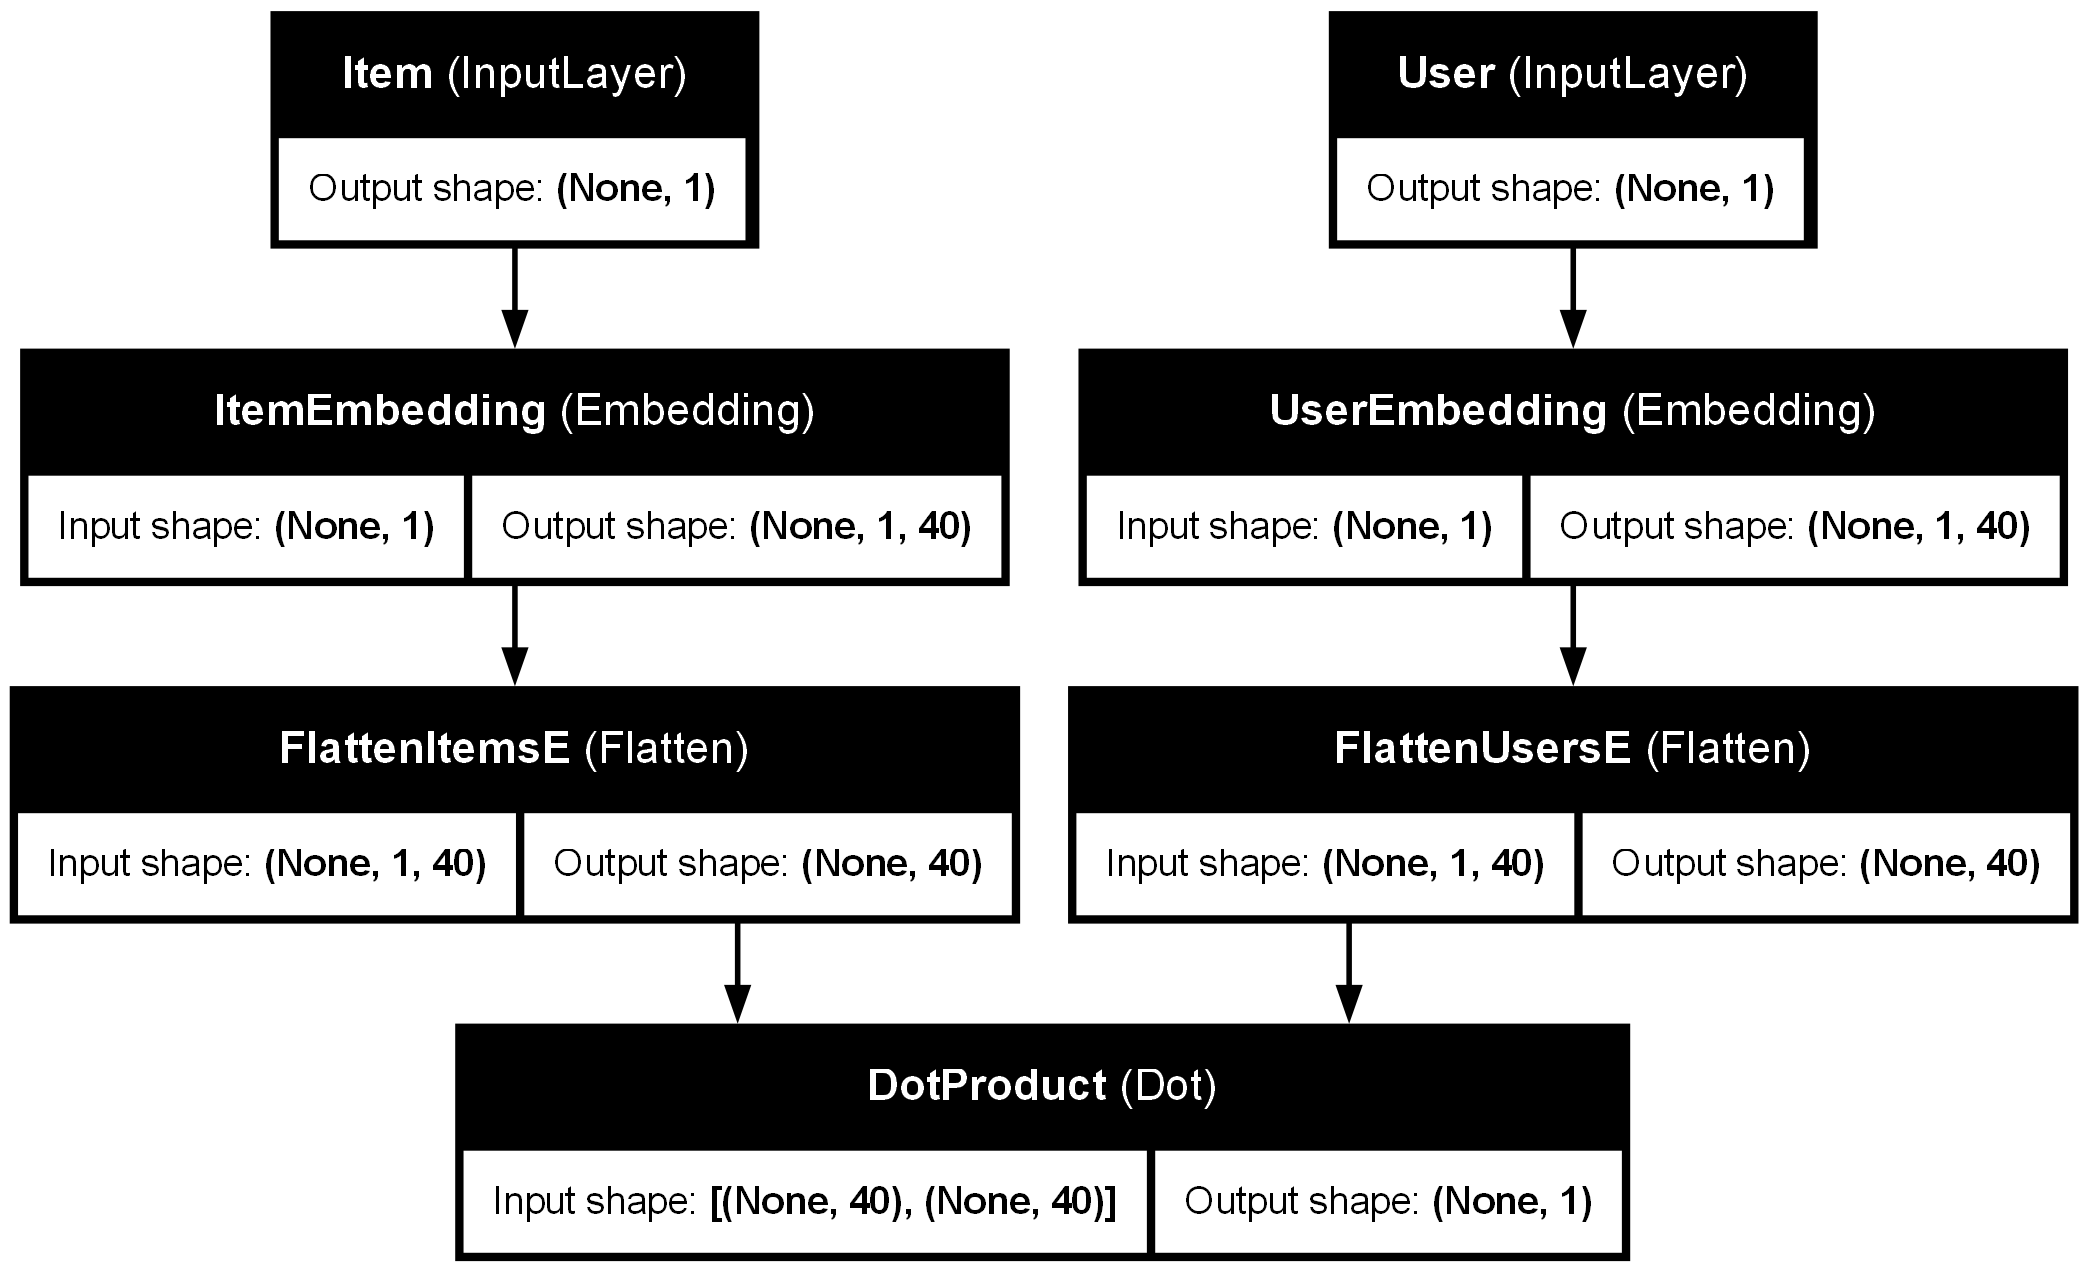

In [16]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/implicit-mf.png" )

## Train the model

In [17]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3972 - val_loss: 5.4015
Epoch 2/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.5027 - val_loss: 5.3923
Epoch 3/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4725 - val_loss: 5.4212
Epoch 4/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.7407 - val_loss: 5.4290
Epoch 5/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2605 - val_loss: 5.4293
CPU times: total: 12.8 s
Wall time: 5.1 s


In [18]:
vis.metrics(output.history)

alt.FacetChart(...)

# Score the model

In [19]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 632us/step - loss: 5.4222


5.285563945770264

## Evaluate the model

In [20]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [21]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [22]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 30s 605us/step
CPU times: total: 1min 3s
Wall time: 47.7 s


In [23]:
predictions.head()

,USER,ITEM,RATING_PRED
0,0,46,0.147496
1,0,116,0.362054
2,0,264,0.160769
3,0,170,0.113659
4,0,201,0.386391


In [24]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 28s 558us/step
CPU times: total: 56.4 s
Wall time: 40.7 s


In [25]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.112811
Precision@K:	0.089394
Recall@K:	0.006116


## Get similar items

In [35]:
from reco.recommend import get_similar

In [36]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: total: 93.8 ms
Wall time: 85.2 ms


In [37]:
item_similar_indices

array([[   0,  404,    6,   21,  196],
       [   1,  464,  897,  944,   80],
       [   2,   89,  449,  805,  542],
       ...,
       [1679, 1055, 1286,  806, 1608],
       [1680, 1315, 1661, 1418, 1161],
       [1681,  896,  909,  554, 1336]])

In [40]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

In [59]:
def show_similar(item_index, item_similar_indices, item_encoder, df_items):
    s = item_similar_indices[item_index]
    movie_ids = item_encoder.inverse_transform(s)

    images = []
    titles = []
    for movie_id in movie_ids:
        movie = df_items[df_items["movie_id"] == movie_id]
        if not movie.empty:
            # Extract just the string value from the Series
            title = movie['title'].values[0]
            titles.append(title)
            
            img_path = "data/posters/" + str(movie_id) + ".0.jpg"
            try:
                images.append(mpimg.imread(img_path))
            except FileNotFoundError:
                try:
                    img_path = "data/posters/" + str(movie_id) + ".jpg"
                    images.append(mpimg.imread(img_path))
                except FileNotFoundError:
                    print(f"Image not found for movie ID {movie_id}")
                    continue

    if not images:
        print("No images found to display")
        return

    # Print just the titles
    for title in titles:
        print(title)

In [60]:
show_similar(0, item_similar_indices, item_encoder, df_items=df_items)

Toy Story (1995)
Mission: Impossible (1996)
Twelve Monkeys (1995)
Braveheart (1995)
Graduate, The (1967)
